* В этом ноутбуке хочу изменить параметр валидации, который отвечает за размер теста - test_size
* В финальном ноутбуке я оставил 7D, в этом хочу провести эксперимент с 14D
* В конце проведу сравнительный анализ

In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!pip install implicit rectools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 11.7 MB/s eta 0:00:00


In [ ]:
import json
import warnings
from collections import defaultdict
from pprint import pprint

import numpy as np
import pandas as pd
import requests
from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender,
)
from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.metrics import MAP, MeanInvUserFreq, calc_metrics
from rectools.model_selection import TimeRangeSplitter
from rectools.models.popular import PopularModel
from scipy.stats import mode
from tqdm.auto import tqdm
from userknn import UserKnn

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 200)

/usr/local/lib/python3.10/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [ ]:
interactions_df = pd.read_csv(
    "/content/drive/MyDrive/itmo_recsys/kion_dataset/interactions.csv"
)
users = pd.read_csv("/content/drive/MyDrive/itmo_recsys/kion_dataset/users.csv")
items = pd.read_csv("/content/drive/MyDrive/itmo_recsys/kion_dataset/items.csv")

interactions_df.rename(
    columns={"last_watch_dt": Columns.Datetime, "total_dur": Columns.Weight},
    inplace=True,
)

interactions = Interactions(interactions_df)

In [ ]:
N_SPLITS = 3
TEST_SIZE = "14D"

In [ ]:
# Init generator of folds
cv = TimeRangeSplitter(
    test_size=TEST_SIZE,
    n_splits=N_SPLITS,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

In [ ]:
cv.get_test_fold_borders(interactions)

[(Timestamp('2021-07-12 00:00:00', freq='14D'),
  Timestamp('2021-07-26 00:00:00', freq='14D')),
 (Timestamp('2021-07-26 00:00:00', freq='14D'),
  Timestamp('2021-08-09 00:00:00', freq='14D')),
 (Timestamp('2021-08-09 00:00:00', freq='14D'),
  Timestamp('2021-08-23 00:00:00', freq='14D'))]

In [ ]:
# calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "map@10": MAP(k=10),
    "novelty": MeanInvUserFreq(k=10),
}

# few simple models to compare
models = {
    "cosine_userknn": CosineRecommender(),  # implicit
    "tfidf_userknn": TFIDFRecommender(),
    "bm25_userknn": BM25Recommender(),
}

In [ ]:
%%time

results = []

fold_iterator = cv.split(interactions, collect_fold_stats=True)

for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
    print(f"\n==================== Fold {i_fold}")
    pprint(fold_info)

    df_train = interactions.df.iloc[train_ids].copy()
    df_test = interactions.df.iloc[test_ids][Columns.UserItem].copy()

    catalog = df_train[Columns.Item].unique()

    for model_name, model in models.items():
        userknn_model = UserKnn(model=model, N_users=50)
        userknn_model.fit(df_train)

        recos = userknn_model.predict(df_test)

        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )

        fold = {"fold": i_fold, "model": model_name}
        fold.update(metric_values)
        results.append(fold)


==================== Fold 0
{'end': Timestamp('2021-07-26 00:00:00', freq='14D'),
 'i_split': 0,
 'start': Timestamp('2021-07-12 00:00:00', freq='14D'),
 'test': 398993,
 'test_items': 7394,
 'test_users': 122488,
 'train': 3239125,
 'train_items': 14730,
 'train_users': 646423}


  0%|          | 0/646423 [00:00<?, ?it/s]

  0%|          | 0/646423 [00:00<?, ?it/s]

  0%|          | 0/646423 [00:00<?, ?it/s]


==================== Fold 1
{'end': Timestamp('2021-08-09 00:00:00', freq='14D'),
 'i_split': 1,
 'start': Timestamp('2021-07-26 00:00:00', freq='14D'),
 'test': 458757,
 'test_items': 7711,
 'test_users': 135624,
 'train': 3892558,
 'train_items': 15085,
 'train_users': 742256}


  0%|          | 0/742256 [00:00<?, ?it/s]

  0%|          | 0/742256 [00:00<?, ?it/s]

  0%|          | 0/742256 [00:00<?, ?it/s]


==================== Fold 2
{'end': Timestamp('2021-08-23 00:00:00', freq='14D'),
 'i_split': 2,
 'start': Timestamp('2021-08-09 00:00:00', freq='14D'),
 'test': 521381,
 'test_items': 7705,
 'test_users': 151629,
 'train': 4649162,
 'train_items': 15415,
 'train_users': 850489}


  0%|          | 0/850489 [00:00<?, ?it/s]

  0%|          | 0/850489 [00:00<?, ?it/s]

  0%|          | 0/850489 [00:00<?, ?it/s]

CPU times: user 5h 15min 22s, sys: 2min 18s, total: 5h 17min 41s
Wall time: 3h 36min 43s


In [ ]:
df_metrics = pd.DataFrame(results)
df_metrics

,fold,model,map@10,novelty
0,0,cosine_userknn,0.004787,7.182565
1,0,tfidf_userknn,0.007761,7.263590
2,0,bm25_userknn,0.002732,8.858159
3,1,cosine_userknn,0.004260,7.333215
4,1,tfidf_userknn,0.006999,7.419020
5,1,bm25_userknn,0.002646,9.043740
6,2,cosine_userknn,0.003716,7.445428
7,2,tfidf_userknn,0.006224,7.513453
8,2,bm25_userknn,0.002503,9.174936


In [ ]:
df_metrics.to_csv("df_metrics_experiment.csv", index=False, sep=";")

In [ ]:
!cp df_metrics_experiment.csv /content/drive/MyDrive/itmo_recsys/lesson_3

In [ ]:
df_metrics = pd.read_csv(
    "/content/drive/MyDrive/itmo_recsys/lesson_3/df_metrics_experiment.csv", sep=";"
)

In [ ]:
df_metrics_14d = (
    df_metrics.groupby("model", as_index=False)
    .agg({"map@10": np.mean, "novelty": np.mean})
    .rename(columns={"map@10": "map@10_14d", "novelty": "novelty_14d"})
)

# из финального ноутбука взял
df_metrics_7d = pd.DataFrame(
    {
        "model": ["bm25_userknn", "cosine_userknn", "tfidf_userknn"],
        "map@10_7d": [0.00269867, 0.0039053333, 0.006333666],
        "novelty_7d": [9.28316866, 7.540823333, 7.638598333],
    }
)

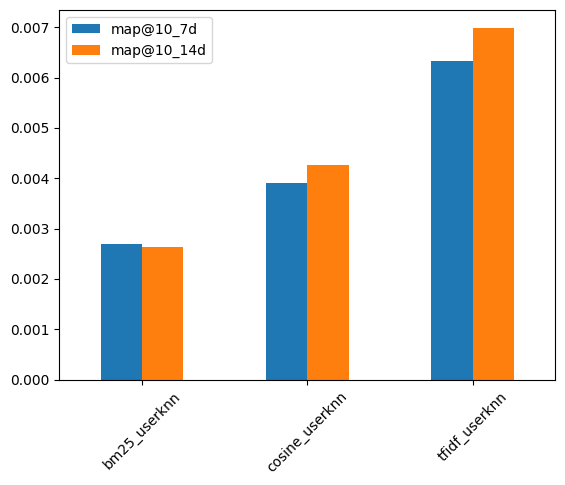

In [ ]:
ax = pd.merge(df_metrics_14d, df_metrics_7d, on="model")[
    ["map@10_7d", "map@10_14d"]
].plot.bar()
ax.set_xticklabels(df_metrics_14d["model"].tolist(), rotation=45);

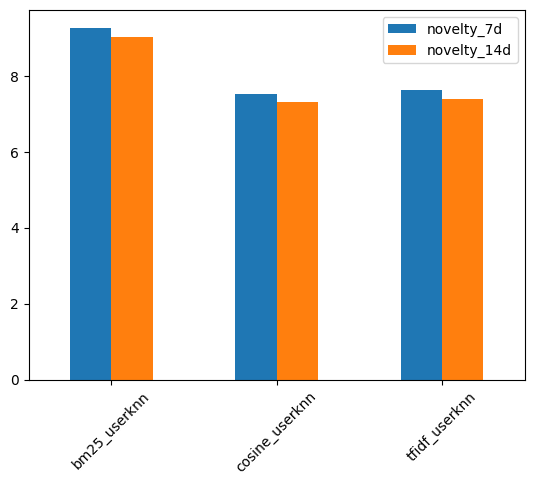

In [ ]:
ax = pd.merge(df_metrics_14d, df_metrics_7d, on="model")[
    ["novelty_7d", "novelty_14d"]
].plot.bar()
ax.set_xticklabels(df_metrics_14d["model"].tolist(), rotation=45);

* Получили интересные результаты: map@10 у 14D на валидации для моей модели tfidf оказался выше, чем у 7D
* Novelty у 7D везде выше, но совсем немного
* Нужно балансировать метриками, которые нужно конкретно для задачи
* Прогон пайплайна с 14D оказался значительно быстрее. 5 часов vs 3 часа 30 минут